In [2]:
# import jsonlines
# from collections import Counter
# import pandas as pd

# data = []
# with jsonlines.open('../Data/Pre_train_model/test.jsonl') as f:

#     for line in f.iter():
       
#         data.append((line['text'], {'labels': line['labels']}))

# extract_data = []
# for dt in data:
#     a_dict = {}
#     text = dt[0]
#     check_label = []
#     for i in dt[1]['labels']:
#         label = i[-1].split('#')[0]
#         check_label.append(label)
#     count_label = Counter(check_label)
#     duplicate_label = []
#     for k, v in count_label.items():
#         if v > 1:
#             duplicate_label.append(k)

#     duplicate = []
#     for i in dt[1]['labels']:
#         label_split = i[-1].split('#')
#         if label_split[0] not in duplicate_label:
#             a_dict[label_split[0]] = label_split[1].lower()
#         else:
#             duplicate.append(i)

#     if duplicate != []:
#         list_pos_remove = []
#         for pos in duplicate:
#             list_pos_remove.append(pos[:2])

#         for d in duplicate:
#             label_split = d[-1].split('#')
#             remove_pos = []
#             for l in list_pos_remove:
#                 if l != d[:2]:
#                     remove_pos.append(l)
#             list_text = list(text)
#             for list_pos in remove_pos:
#                 for num in range(list_pos[0], list_pos[1]):
#                     list_text[num] = ''
            
#             copy_dict = a_dict.copy()
#             copy_dict['review'] = ''.join(list_text)
#             copy_dict[label_split[0]] = label_split[1].lower()
#             extract_data.append(copy_dict)
#     else:
#         a_dict['review'] = text
#         extract_data.append(a_dict)
#     print('='*100)
# df = pd.DataFrame(extract_data)
# df = df[['review', 'BATTERY', 'CAMERA', 'GENERAL', 'SER&ACC', 'PERFORMANCE', 'DESIGN',
#        'FEATURES', 'PRICE', 'SCREEN', 'STORAGE']]
# df.to_csv(r'../Data/Pre_train_model/test.csv', index=False)

# Install & import libraries

In [3]:
import numpy as np
import tensorflow as tf
import torch
import math
import pandas as pd
import os
from text_preprocessed import preprocessing_text

# Import datasets

In [4]:
# TRAIN_PATH = 'VLSP_Restaurant/train.csv'
# VAL_PATH = 'VLSP_Restaurant/dev.csv'
# TEST_PATH = 'VLSP_Restaurant/test.csv'

TRAIN_PATH = '../Data/Pre_train_model/train.csv'
VAL_PATH = '../Data/Pre_train_model/dev.csv'
TEST_PATH = '../Data/Pre_train_model/test.csv'

In [5]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2444 | INFO | PyTorch version 2.1.2 available.
2444 | INFO | TensorFlow version 2.13.0 available.


DatasetDict({
    train: Dataset({
        features: ['review', 'BATTERY', 'CAMERA', 'GENERAL', 'SER&ACC', 'PERFORMANCE', 'DESIGN', 'FEATURES', 'PRICE', 'SCREEN', 'STORAGE'],
        num_rows: 10832
    })
    val: Dataset({
        features: ['review', 'BATTERY', 'CAMERA', 'GENERAL', 'SER&ACC', 'PERFORMANCE', 'DESIGN', 'FEATURES', 'PRICE', 'SCREEN', 'STORAGE'],
        num_rows: 1591
    })
    test: Dataset({
        features: ['review', 'BATTERY', 'CAMERA', 'GENERAL', 'SER&ACC', 'PERFORMANCE', 'DESIGN', 'FEATURES', 'PRICE', 'SCREEN', 'STORAGE'],
        num_rows: 3120
    })
})

In [6]:
df_train = pd.read_csv(TRAIN_PATH)
df_train.fillna('None', inplace=True)

df_val = pd.read_csv(VAL_PATH)
df_val.fillna('None', inplace=True)

df_test = pd.read_csv(TEST_PATH)
df_test.fillna('None', inplace=True)

df_train.head()

,review,BATTERY,CAMERA,GENERAL,SER&ACC,PERFORMANCE,DESIGN,FEATURES,PRICE,SCREEN,STORAGE
0,Pin Sài tầm 50h cho pin 100/100. Camera ổn ......,positive,positive,positive,positive,None,None,None,None,None,None
1,Lag và hao pin là cái tóm tắt về máy. S...,negative,None,negative,None,negative,None,None,None,None,None
2,Tất cả đều ổn ngoại trừ lúc haizz. Cam chụp c...,positive,neutral,None,None,None,None,None,None,None,None
3,Tất cả đều ổn ngoại trừ lúc máy nóng lên thì p...,negative,neutral,None,None,None,None,None,None,None,None
4,"Ok mua máy ở TGDD chính sách đổi trả rất tốt,r...",None,None,None,positive,None,None,None,None,None,None


## Standardlize outputs

In [7]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            one_hot = []
            sentiment = df.iloc[row, col]
            if sentiment == 'None': 
                one_hot = [1, 0, 0, 0] # None
            elif sentiment == 'positive': 
                one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 'negative': 
                one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 'neutral': 
                one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [8]:
y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (10832, 10, 4)
Validate outputs: (1591, 10, 4)
Test outputs: (3120, 10, 4)


array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

# Preprocessing

In [9]:
#@title **Choose a pretrained model for Vietnamese that support Tensorflow from [huggingface](https://huggingface.co/transformers/pretrained_models.html)**
#@markdown
#@markdown | <h4>Model id                        </h4> | <h4>Summary                                                                              </h4> | <h4>Description                                                                                                       </h4> | <h4>Architecture</h4> |
#@markdown | ----------------------------------------- | ---------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- | --------------------- |
#@markdown | <p>vinai/phobert-base                </p> | <p>135M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>vinai/phobert-large               </p> | <p>370M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>bert-base-multilingual-uncased    </p> | <p>12-layer, 768-hidden, 12-heads, 168M parameters                                        </p> | <p>(Original, not recommended) Trained on lower-cased text in the top 102 languages with the largest Wikipedias        </p> | <p>BERT          </p> |
#@markdown | <p>bert-base-multilingual-cased      </p> | <p>12-layer, 768-hidden, 12-heads, 179M parameters                                        </p> | <p>(New, recommended) Trained on cased text in the top 104 languages with the largest Wikipedias                       </p> | <p>BERT          </p> |
#@markdown | <p>distilbert-base-multilingual-cased</p> | <p>6-layer, 768-hidden, 12-heads, 134M parameters                                         </p> | <p>The multilingual DistilBERT model distilled from the Multilingual BERT model bert-base-multilingual-cased checkpoint</p> | <p>DistilBERT    </p> |
#@markdown >

PRETRAINED_MODEL = 'vinai/phobert-base' #@param ['vinai/phobert-base', 'vinai/phobert-large', 'bert-base-multilingual-uncased','bert-base-multilingual-cased ', 'distilbert-base-multilingual-cased'] {allow-input: true}

## Tokenizing

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [11]:
def tokenize_function(dataset):
    clean_texts = list(map(preprocessing_text, dataset['review']))
    token = tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)
    return token

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map: 100%|██████████| 3120/3120 [01:55<00:00, 27.04 examples/s]

input_ids of sentence 1484: [0, 265, 204, 12496, 7975, 26, 175, 265, 11, 107, 43, 204, 36, 1774, 24777, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Prepare for TensorFlow

In [13]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = 'model_weights'
BATCH_SIZE = 20

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE

EPOCHS = 5

In [14]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-3]).with_format('tensorflow')

In [15]:
from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

# Fine-tuning with TensorFlow

## Define the model

In [17]:
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LSTM

def create_model(optimizer):
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'),
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'),
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]),
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)

    outputs = concatenate([
        Dense(
            units = 4,
            activation = 'softmax',
            name = label.replace('#', '-').replace('&', '_'),
        )(x) for label in df_train.columns[1:]
    ], axis = -1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

## Optimzers

In [18]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-6)
type(optimizer)

keras.src.optimizers.adam.Adam

## Callbacks

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH,
    options = options,
    verbose = 1
)

## Training

In [ ]:
# with strategy.scope(): # For using TPU
model = create_model(optimizer)
history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    validation_steps = VALIDATION_STEPS,
    # steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks = [
        # schedule_lr_callback, # When not use AdamW
        # reduce_lr_callback, # When not use AdamW
        early_stop_callback,
        # checkpoint_callback
    ],
    verbose = 1,
)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/5


10148 | WARNING | Gradients do not exist for variables ['tf_roberta_model/roberta/pooler/dense/kernel:0', 'tf_roberta_model/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


10148 | WARNING | Gradients do not exist for variables ['tf_roberta_model/roberta/pooler/dense/kernel:0', 'tf_roberta_model/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


10148 | WARNING | Gradients do not exist for variables ['tf_roberta_model/roberta/pooler/dense/kernel:0', 'tf_roberta_model/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


10148 | WARNING | Gradients do not exist for variables ['tf_roberta_model/roberta/pooler/dense/kernel:0', 'tf_roberta_model/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


542/542 [==============================] - 10459s 19s/step - loss: 0.3836 - val_loss: 0.3280
Epoch 2/5
542/542 [==============================] - 11641s 21s/step - loss: 0.3214 - val_loss: 0.3045
Epoch 3/5
542/542 [==============================] - 11433s 21s/step - loss: 0.2961 - val_loss: 0.2753
Epoch 4/5
542/542 [==============================] - 7774s 14s/step - loss: 0.2679 - val_loss: 0.2517
Epoch 5/5
542/542 [==============================] - 7637s 14s/step - loss: 0.2445 - val_loss: 0.2336


In [ ]:
model.save_weights(f'model_weights/weights_3.h5')

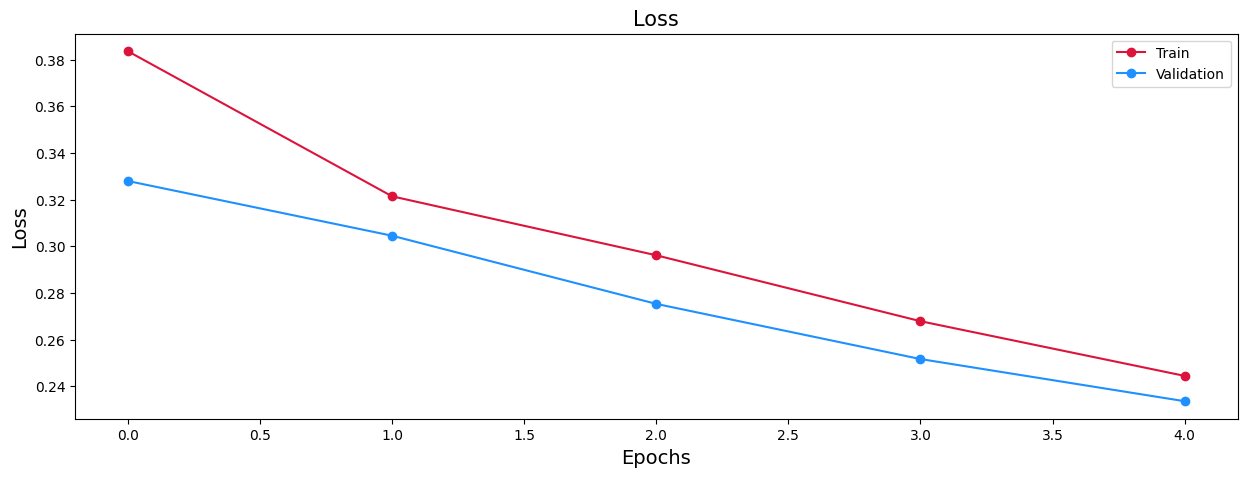

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
plt.show()

## Reload the model

In [20]:
reloaded_model = create_model(optimizer)
reloaded_model.load_weights('model_weights/weights_3.h5')
reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                              

# Prediction

In [ ]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Predict on test data

In [22]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)

In [ ]:
y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
# reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

156/156 [==============================] - 651s 4s/step


## Predict random text

In [35]:
text = """
Rất tin tưởng Tiki khi đặt mua điện thoại tại đây,
Đã mua iphone 13 pro, promax, xiaomi, giờ là 15 pro max. 
Mọi thứ đều rất ok và không có lỗi lầm gì cả.
Chúc Tiki ngày càng phát triển hơn nữa
"""

example_input = preprocessing_text(text)
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}
replacements = {0: 'None', 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = ['BATTERY', 'CAMERA', 'GENERAL', 'SER&ACC', 'PERFORMANCE', 'DESIGN',
             'FEATURES', 'PRICE', 'SCREEN', 'STORAGE']
pred = predict(reloaded_model, Dataset.from_tensor_slices(features))

pred_dict = {}
pred_dict['Review'] = text
for i in range(10):
    pred_dict[categories[i]] = replacements[pred[0][i]]

pred_dict

{'Review': '\nRất tin tưởng Tiki khi đặt mua điện thoại tại đây,\nĐã mua iphone 13 pro, promax, xiaomi, giờ là 15 pro max. \nMọi thứ đều rất ok và không có lỗi lầm gì cả.\nChúc Tiki ngày càng phát triển hơn nữa\n',
 'BATTERY': 'None',
 'CAMERA': 'None',
 'GENERAL': 'positive',
 'SER&ACC': 'positive',
 'PERFORMANCE': 'None',
 'DESIGN': 'None',
 'FEATURES': 'None',
 'PRICE': 'None',
 'SCREEN': 'None',
 'STORAGE': 'None'}

# Report metrics

## Aspect Detection

In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.8516    0.9439    0.8954     22114
     BATTERY     0.9505    0.9123    0.9310      1517
      CAMERA     0.8647    0.8122    0.8376       921
      DESIGN     0.8252    0.2092    0.3338       564
    FEATURES     0.7403    0.2592    0.3840      1034
     GENERAL     0.7152    0.7206    0.7179      1854
 PERFORMANCE     0.7766    0.7312    0.7532      1674
       PRICE     1.0000    0.0000    0.0000       399
      SCREEN     0.6667    0.0590    0.1084       407
     SER&ACC     0.9060    0.5322    0.6705       652
     STORAGE     1.0000    0.0000    0.0000        64

    accuracy                         0.8437     31200
   macro avg     0.8452    0.4709    0.5120     31200
weighted avg     0.8414    0.8437    0.8219     31200



## Polarity Detection

In [ ]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))

In [ ]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.8516    0.9439    0.8954     22114
    positive     0.7008    0.6656    0.6827      5711
    negative     0.7194    0.3310    0.4534      2749
     neutral     0.0000    0.0000    0.0000       626

    accuracy                         0.8200     31200
   macro avg     0.5679    0.4851    0.5079     31200
weighted avg     0.7953    0.8200    0.7996     31200



c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Aspect + Polarity

In [ ]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [ ]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                      precision    recall  f1-score   support

        BATTERY,None     0.9201    0.9551    0.9373      1603
    BATTERY,negative     0.7315    0.6049    0.6622       491
     BATTERY,neutral     1.0000    0.0000    0.0000        99
    BATTERY,positive     0.7543    0.8544    0.8012       927
         CAMERA,None     0.9233    0.9468    0.9349      2199
     CAMERA,negative     0.7582    0.4735    0.5829       245
      CAMERA,neutral     1.0000    0.0000    0.0000       134
     CAMERA,positive     0.6390    0.8395    0.7257       542
         DESIGN,None     0.8502    0.9902    0.9149      2556
     DESIGN,negative     1.0000    0.0000    0.0000       131
      DESIGN,neutral     1.0000    0.0000    0.0000        27
     DESIGN,positive     0.7273    0.2562    0.3789       406
       FEATURES,None     0.7223    0.9549    0.8225      2086
   FEATURES,negative     0.7034    0.3611    0.4772       637
    FEATURES,neutral     1.0000    0.0000    0.0000        46
   FEAT

## Summary

In [ ]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [ ]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.845176,0.470890,0.511985,0.843686
Polarity Detection,0.567940,0.485129,0.507881,0.820032
Aspect + Polarity,0.862923,0.387497,0.387117,0.820032
